# Synthetic Dataset & Scalability
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure and determine their scalability to datasets with a large number of observations.__  

As a reminder, unique pairwise distances in a dataset with _n_ cells is calculated as:  
$$D=(n*(n-1))/2$$  
  
To benchmark these techniques, we are using a **"Swiss Roll"** dataset built using `sklearn.datasets.make_swiss_roll()`.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

In [3]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

In [4]:
# create dictionary for dumping results into
final_distance_stats = {1000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}},
                        5000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}},
                        10000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}}, 
                        50000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}}
                       }

---
### 1K-Point Swiss Roll

In [5]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

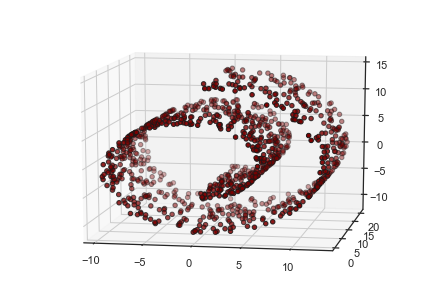

In [6]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [7]:
swiss_1k = sc.AnnData(X=X) # initialize AnnData
swiss_1k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_1k

AnnData object with n_obs × n_vars = 1000 × 3 
    obs: 'pos'

In [8]:
# perform PCA
%time sc.tl.pca(swiss_1k, n_comps=2)

CPU times: user 6.84 ms, sys: 2.68 ms, total: 9.52 ms
Wall time: 2.23 ms


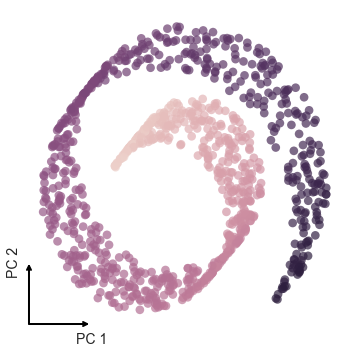

In [10]:
DR_plot(dim_name='PC').plot(swiss_1k.obsm['X_pca'], color=swiss_1k.obs['pos'])

In [9]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(swiss_1k, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 2.85 s, sys: 106 ms, total: 2.95 s
Wall time: 2.56 s


In [11]:
# perform UMAP
%time sc.tl.umap(swiss_1k, random_state=18)

CPU times: user 3.04 s, sys: 126 ms, total: 3.17 s
Wall time: 2.6 s


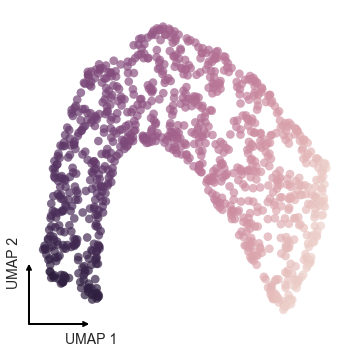

In [12]:
DR_plot(dim_name='UMAP').plot(swiss_1k.obsm['X_umap'], color=swiss_1k.obs['pos'])

In [13]:
# perform t-SNE
%time sc.tl.tsne(swiss_1k, use_rep='X', perplexity=30, random_state=18)

CPU times: user 3.86 s, sys: 16.4 ms, total: 3.88 s
Wall time: 3.81 s


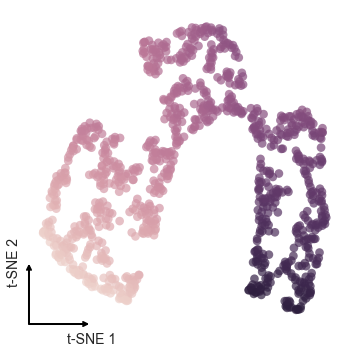

In [14]:
DR_plot(dim_name='t-SNE').plot(swiss_1k.obsm['X_tsne'], color=swiss_1k.obs['pos'])

In [70]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(swiss_1k, latent='X_pca', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))
final_distance_stats[1000]['R']['PCA'], final_distance_stats[1000]['EMD']['PCA'], final_distance_stats[1000]['Knn Pres.']['PCA'] = pca_corr[0], pca_EMD, pca_knnP

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
CPU times: user 501 ms, sys: 84.9 ms, total: 586 ms
Wall time: 185 ms
R: 0.8567
EMD: 0.0386
Knn %: 95.6665


In [71]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(swiss_1k, latent='X_tsne', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats[1000]['R']['t-SNE'], final_distance_stats[1000]['EMD']['t-SNE'], final_distance_stats[1000]['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
CPU times: user 498 ms, sys: 83.1 ms, total: 581 ms
Wall time: 172 ms
R: 0.38
EMD: 0.0499
Knn %: 96.6576


In [72]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(swiss_1k, latent='X_umap', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats[1000]['R']['UMAP'], final_distance_stats[1000]['EMD']['UMAP'], final_distance_stats[1000]['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
CPU times: user 497 ms, sys: 70.5 ms, total: 567 ms
Wall time: 156 ms
R: 0.2716
EMD: 0.0772
Knn %: 96.7755


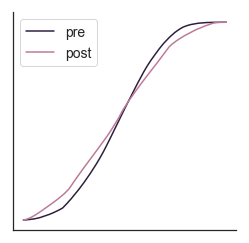

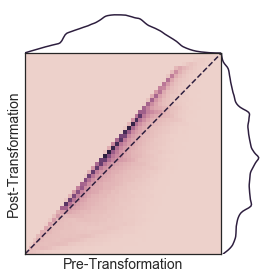

In [18]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_1k.uns['X_norm_distances'], swiss_1k.uns['X_pca_norm_distances'])
joint_plot_distance_correlation(swiss_1k.uns['X_norm_distances'], swiss_1k.uns['X_pca_norm_distances'])

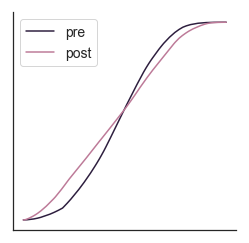

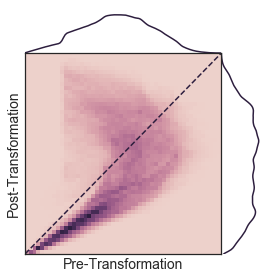

In [19]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_1k.uns['X_norm_distances'], swiss_1k.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(swiss_1k.uns['X_norm_distances'], swiss_1k.uns['X_tsne_norm_distances'])

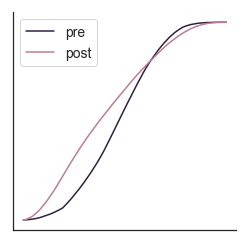

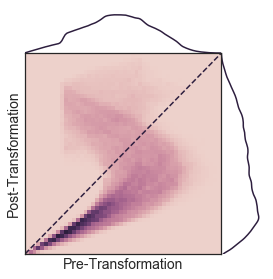

In [20]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_1k.uns['X_norm_distances'], swiss_1k.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(swiss_1k.uns['X_norm_distances'], swiss_1k.uns['X_umap_norm_distances'])

---
### 5K-Point Swiss Roll

In [21]:
X, t = datasets.make_swiss_roll(n_samples=5000, noise=0.0, random_state=18)

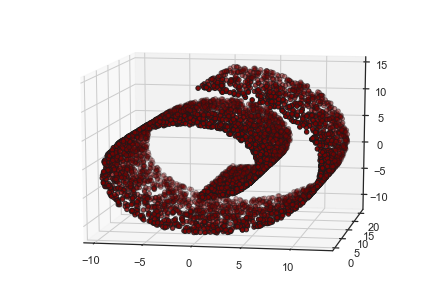

In [22]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [23]:
swiss_5k = sc.AnnData(X=X) # initialize AnnData
swiss_5k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_5k

AnnData object with n_obs × n_vars = 5000 × 3 
    obs: 'pos'

In [24]:
# perform PCA
%time sc.tl.pca(swiss_5k, n_comps=2)

CPU times: user 7.08 ms, sys: 2.53 ms, total: 9.61 ms
Wall time: 2.22 ms


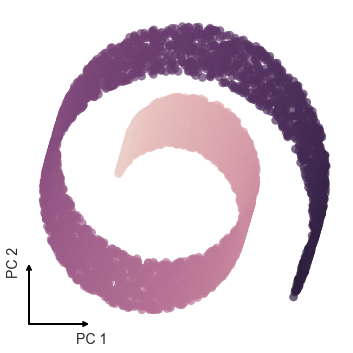

In [26]:
DR_plot(dim_name='PC').plot(swiss_5k.obsm['X_pca'], color=swiss_5k.obs['pos'])

In [25]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(swiss_5k, n_neighbors=70, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 2.04 s, sys: 374 ms, total: 2.41 s
Wall time: 992 ms


In [27]:
# perform UMAP
%time sc.tl.umap(swiss_5k, random_state=18)

CPU times: user 9.46 s, sys: 151 ms, total: 9.61 s
Wall time: 8.55 s


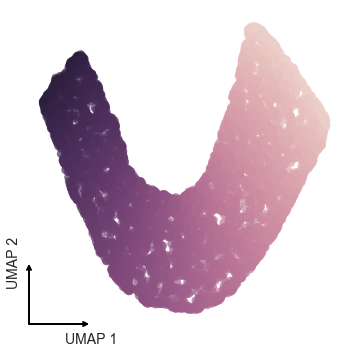

In [28]:
DR_plot(dim_name='UMAP').plot(swiss_5k.obsm['X_umap'], color=swiss_5k.obs['pos'])

In [29]:
# perform t-SNE
%time sc.tl.tsne(swiss_5k, use_rep='X', perplexity=70, random_state=18)

CPU times: user 26.7 s, sys: 145 ms, total: 26.9 s
Wall time: 26.8 s


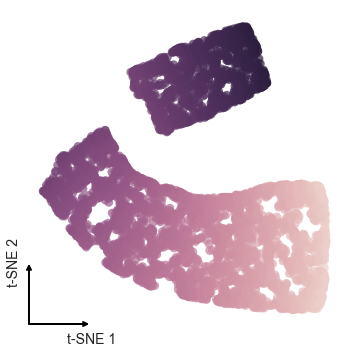

In [30]:
DR_plot(dim_name='t-SNE').plot(swiss_5k.obsm['X_tsne'], color=swiss_5k.obs['pos'])

In [73]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(swiss_5k, latent='X_pca', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))
final_distance_stats[5000]['R']['PCA'], final_distance_stats[5000]['EMD']['PCA'], final_distance_stats[5000]['Knn Pres.']['PCA'] = pca_corr[0], pca_EMD, pca_knnP

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
CPU times: user 5.96 s, sys: 738 ms, total: 6.7 s
Wall time: 6.55 s
R: 0.8473
EMD: 0.0392
Knn %: 99.0959


In [74]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(swiss_5k, latent='X_tsne', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats[5000]['R']['t-SNE'], final_distance_stats[5000]['EMD']['t-SNE'], final_distance_stats[5000]['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
CPU times: user 5.79 s, sys: 439 ms, total: 6.22 s
Wall time: 6.22 s
R: 0.4097
EMD: 0.0457
Knn %: 99.3414


In [75]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(swiss_5k, latent='X_umap', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats[5000]['R']['UMAP'], final_distance_stats[5000]['EMD']['UMAP'], final_distance_stats[5000]['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
CPU times: user 5.71 s, sys: 310 ms, total: 6.02 s
Wall time: 5.72 s
R: 0.303
EMD: 0.0893
Knn %: 99.3524


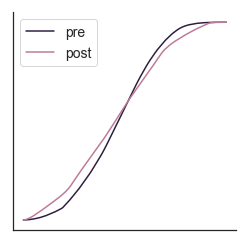

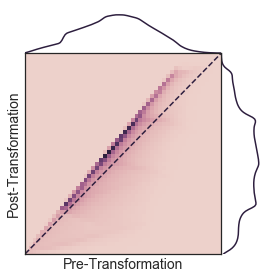

In [34]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_5k.uns['X_norm_distances'], swiss_5k.uns['X_pca_norm_distances'])
joint_plot_distance_correlation(swiss_5k.uns['X_norm_distances'], swiss_5k.uns['X_pca_norm_distances'])

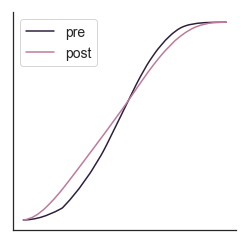

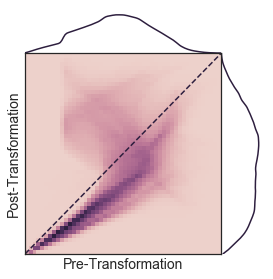

In [35]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_5k.uns['X_norm_distances'], swiss_5k.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(swiss_5k.uns['X_norm_distances'], swiss_5k.uns['X_tsne_norm_distances'])

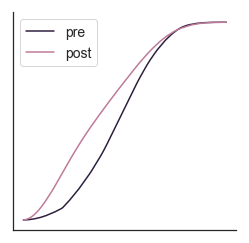

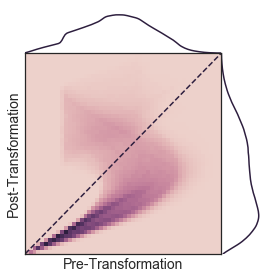

In [36]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_5k.uns['X_norm_distances'], swiss_5k.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(swiss_5k.uns['X_norm_distances'], swiss_5k.uns['X_umap_norm_distances'])

---
### 10K-Point Swiss Roll

In [37]:
X, t = datasets.make_swiss_roll(n_samples=10000, noise=0.0, random_state=18)

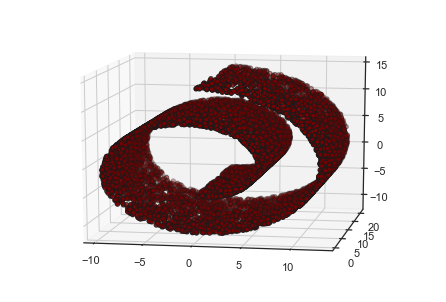

In [38]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [39]:
swiss_10k = sc.AnnData(X=X) # initialize AnnData
swiss_10k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_10k

AnnData object with n_obs × n_vars = 10000 × 3 
    obs: 'pos'

In [40]:
# perform PCA
%time sc.tl.pca(swiss_10k, n_comps=2)

CPU times: user 7.42 ms, sys: 16.5 ms, total: 23.9 ms
Wall time: 3.95 ms


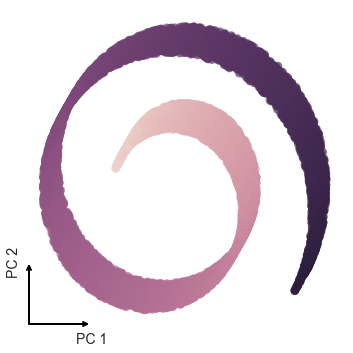

In [42]:
DR_plot(dim_name='PC').plot(swiss_10k.obsm['X_pca'], color=swiss_10k.obs['pos'])

In [41]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(swiss_10k, n_neighbors=100, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 7.83 s, sys: 65.7 ms, total: 7.89 s
Wall time: 7.88 s


In [43]:
# perform UMAP
%time sc.tl.umap(swiss_10k, random_state=18)

CPU times: user 21.4 s, sys: 385 ms, total: 21.8 s
Wall time: 19.1 s


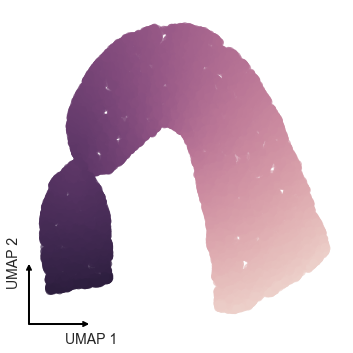

In [44]:
DR_plot(dim_name='UMAP').plot(swiss_10k.obsm['X_umap'], color=swiss_10k.obs['pos'])

In [45]:
# perform t-SNE
%time sc.tl.tsne(swiss_10k, use_rep='X', perplexity=100, random_state=18)

CPU times: user 1min 9s, sys: 790 ms, total: 1min 10s
Wall time: 1min 10s


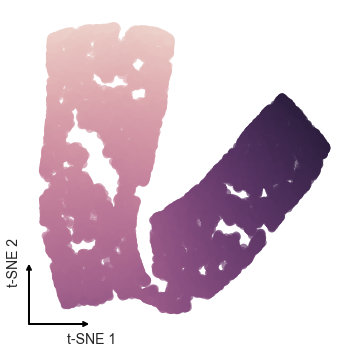

In [46]:
DR_plot(dim_name='t-SNE').plot(swiss_10k.obsm['X_tsne'], color=swiss_10k.obs['pos'])

In [47]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(swiss_10k, latent='X_pca', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))
final_distance_stats[10000]['R']['PCA'], final_distance_stats[10000]['EMD']['PCA'], final_distance_stats[10000]['Knn Pres.']['PCA'] = pca_corr[0], pca_EMD, pca_knnP

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X
k-nearest neighbor calculation for X_pca
Determining nearest neighbor preservation

Done!
CPU times: user 31.8 s, sys: 1.76 s, total: 33.5 s
Wall time: 33 s
R: 0.8512
EMD: 0.051
Knn %: 99.5188


In [48]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(swiss_10k, latent='X_tsne', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats[10000]['R']['t-SNE'], final_distance_stats[10000]['EMD']['t-SNE'], final_distance_stats[10000]['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 29.5 s, sys: 1.42 s, total: 31 s
Wall time: 30.4 s
R: 0.4153
EMD: 0.0448
Knn %: 99.6684


In [49]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(swiss_10k, latent='X_umap', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats[10000]['R']['UMAP'], final_distance_stats[10000]['EMD']['UMAP'], final_distance_stats[10000]['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 28.7 s, sys: 1.35 s, total: 30 s
Wall time: 29.5 s
R: 0.3486
EMD: 0.0528
Knn %: 99.6673


CPU times: user 24.1 s, sys: 1.31 s, total: 25.5 s
Wall time: 25.2 s


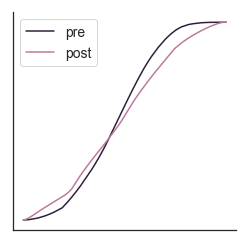

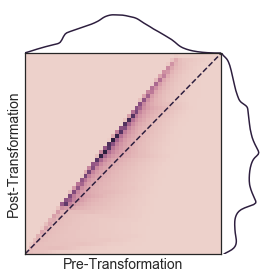

In [50]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_10k.uns['X_norm_distances'], swiss_10k.uns['X_pca_norm_distances'])
joint_plot_distance_correlation(swiss_10k.uns['X_norm_distances'], swiss_10k.uns['X_pca_norm_distances'])

CPU times: user 23.8 s, sys: 525 ms, total: 24.4 s
Wall time: 24 s


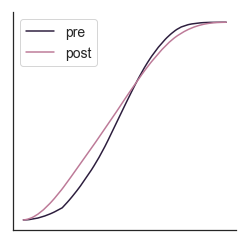

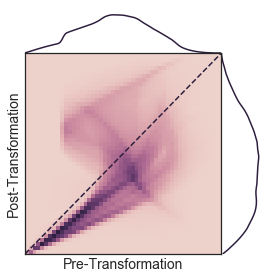

In [51]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_10k.uns['X_norm_distances'], swiss_10k.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(swiss_10k.uns['X_norm_distances'], swiss_10k.uns['X_tsne_norm_distances'])

CPU times: user 24.1 s, sys: 1.54 s, total: 25.6 s
Wall time: 25.3 s


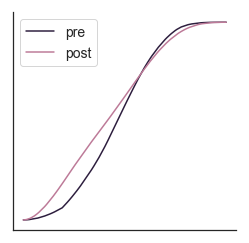

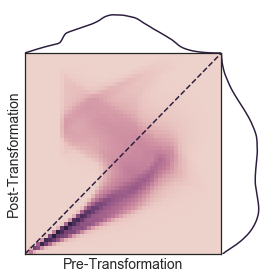

In [52]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_10k.uns['X_norm_distances'], swiss_10k.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(swiss_10k.uns['X_norm_distances'], swiss_10k.uns['X_umap_norm_distances'])

---
### 50K-Point Swiss Roll

In [53]:
X, t = datasets.make_swiss_roll(n_samples=50000, noise=0.0, random_state=18)

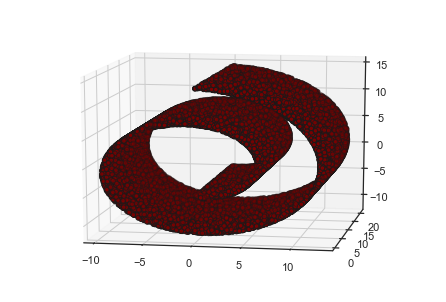

In [54]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [55]:
swiss_50k = sc.AnnData(X=X) # initialize AnnData
swiss_50k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_50k

AnnData object with n_obs × n_vars = 50000 × 3 
    obs: 'pos'

In [56]:
# perform PCA
%time sc.tl.pca(swiss_50k, n_comps=2)

CPU times: user 31.7 ms, sys: 53.8 ms, total: 85.5 ms
Wall time: 12.9 ms


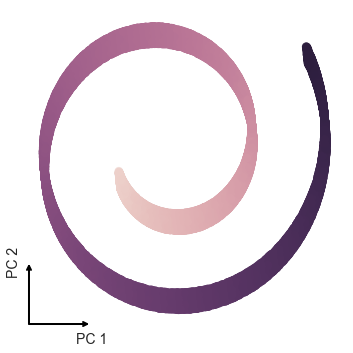

In [57]:
DR_plot(dim_name='PC').plot(swiss_50k.obsm['X_pca'], color=swiss_50k.obs['pos'])

In [58]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(swiss_50k, n_neighbors=225, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 59.7 s, sys: 328 ms, total: 1min
Wall time: 59.9 s


In [59]:
# perform UMAP
%time sc.tl.umap(swiss_50k, random_state=18)

CPU times: user 1min 42s, sys: 3.7 s, total: 1min 46s
Wall time: 1min


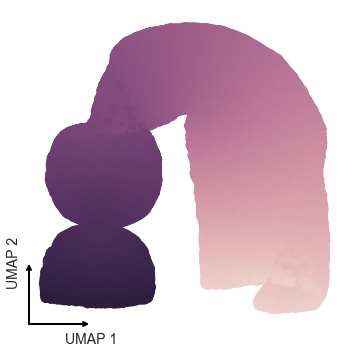

In [60]:
DR_plot(dim_name='UMAP').plot(swiss_50k.obsm['X_umap'], color=swiss_50k.obs['pos'])

In [61]:
# perform t-SNE
%time sc.tl.tsne(swiss_50k, use_rep='X', perplexity=225, random_state=18)

CPU times: user 10min 12s, sys: 8.08 s, total: 10min 20s
Wall time: 10min 20s


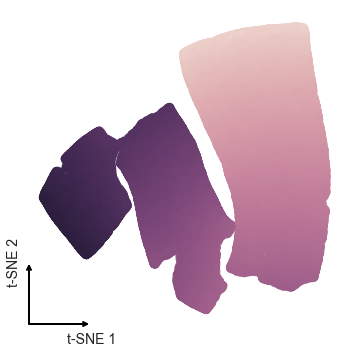

In [62]:
DR_plot(dim_name='t-SNE').plot(swiss_50k.obsm['X_tsne'], color=swiss_50k.obs['pos'])

In [63]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(swiss_50k, latent='X_pca', native='X', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))
final_distance_stats[50000]['R']['PCA'], final_distance_stats[50000]['EMD']['PCA'], final_distance_stats[50000]['Knn Pres.']['PCA'] = pca_corr[0], pca_EMD, pca_knnP

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Downsampling to 49995000 total cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X
k-nearest neighbor calculation for X_pca
Determining nearest neighbor preservation

Done!
CPU times: user 2min 22s, sys: 24.5 s, total: 2min 47s
Wall time: 3min 3s
R: 0.851
EMD: 0.0489
Knn %: 99.8986


In [64]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(swiss_50k, latent='X_tsne', native='X', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats[50000]['R']['t-SNE'], final_distance_stats[50000]['EMD']['t-SNE'], final_distance_stats[50000]['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Calculating unique distances for latent space, X_tsne
Downsampling to 49995000 total cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 2min 14s, sys: 59.4 s, total: 3min 14s
Wall time: 3min 36s
R: 0.3967
EMD: 0.0656
Knn %: 99.9329


In [65]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(swiss_50k, latent='X_umap', native='X', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats[50000]['R']['UMAP'], final_distance_stats[50000]['EMD']['UMAP'], final_distance_stats[50000]['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Calculating unique distances for latent space, X_umap
Downsampling to 49995000 total cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 2min 19s, sys: 1min 38s, total: 3min 58s
Wall time: 6min 4s
R: 0.4271
EMD: 0.0474
Knn %: 99.9277


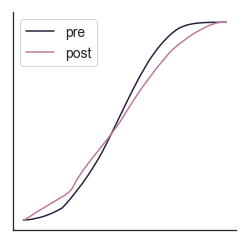

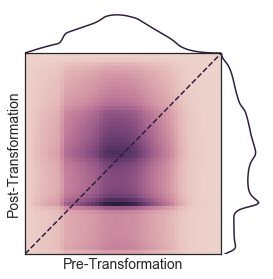

In [66]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_50k.uns['X_norm_distances'], swiss_50k.uns['X_pca_norm_distances'])
joint_plot_distance_correlation(swiss_50k.uns['X_norm_distances'], swiss_50k.uns['X_pca_norm_distances'])

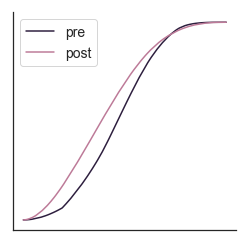

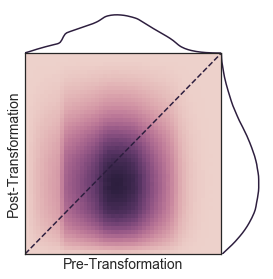

In [67]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_50k.uns['X_norm_distances'], swiss_50k.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(swiss_50k.uns['X_norm_distances'], swiss_50k.uns['X_tsne_norm_distances'])

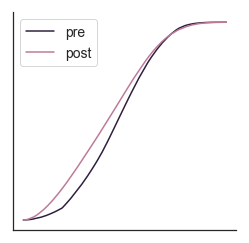

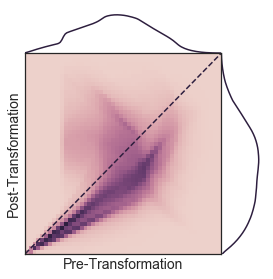

In [68]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(swiss_50k.uns['X_norm_distances'], swiss_50k.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(swiss_50k.uns['X_norm_distances'], swiss_50k.uns['X_umap_norm_distances'])

---
### Aggregate Results

In [86]:
stats_1k = pd.DataFrame(final_distance_stats[1000])
stats_1k['n'] = 1000
stats_1k['DR'] = stats_1k.index

In [87]:
stats_5k = pd.DataFrame(final_distance_stats[5000])
stats_5k['n'] = 5000
stats_5k['DR'] = stats_5k.index

In [88]:
stats_10k = pd.DataFrame(final_distance_stats[10000])
stats_10k['n'] = 10000
stats_10k['DR'] = stats_10k.index

In [89]:
stats_50k = pd.DataFrame(final_distance_stats[50000])
stats_50k['n'] = 50000
stats_50k['DR'] = stats_50k.index

In [90]:
from functools import reduce

In [92]:
df_merged = reduce(lambda  left,right: left.append(right, ignore_index=True), 
                   [stats_1k, stats_5k, stats_10k, stats_50k])

In [103]:
df_merged.to_csv('outputs/synthetic_stats.csv')

In [2]:
df_merged = pd.read_csv('outputs/synthetic_stats.csv')

In [3]:
R = pd.DataFrame(df_merged.loc[df_merged['DR']=='PCA', 'R'])

In [4]:
R = R.rename(columns={'R':'PCA'})

In [5]:
R['t-SNE'] = df_merged.loc[df_merged['DR']=='t-SNE','R'].values

In [6]:
R['UMAP'] = df_merged.loc[df_merged['DR']=='UMAP','R'].values

In [7]:
R.index = [1000,5000,10000,50000]

In [9]:
EMD = pd.DataFrame(df_merged.loc[df_merged['DR']=='PCA', 'EMD'])

In [10]:
EMD = EMD.rename(columns={'EMD':'PCA'})

In [11]:
EMD['t-SNE'] = df_merged.loc[df_merged['DR']=='t-SNE','EMD'].values

In [12]:
EMD['UMAP'] = df_merged.loc[df_merged['DR']=='UMAP','EMD'].values

In [13]:
EMD.index = [1000,5000,10000,50000]

In [14]:
knn = pd.DataFrame(df_merged.loc[df_merged['DR']=='PCA', 'Knn Pres.'])

In [15]:
knn = knn.rename(columns={'Knn Pres.':'PCA'})

In [16]:
knn['t-SNE'] = df_merged.loc[df_merged['DR']=='t-SNE','Knn Pres.'].values

In [17]:
knn['UMAP'] = df_merged.loc[df_merged['DR']=='UMAP','Knn Pres.'].values

In [18]:
knn.index = [1000,5000,10000,50000]

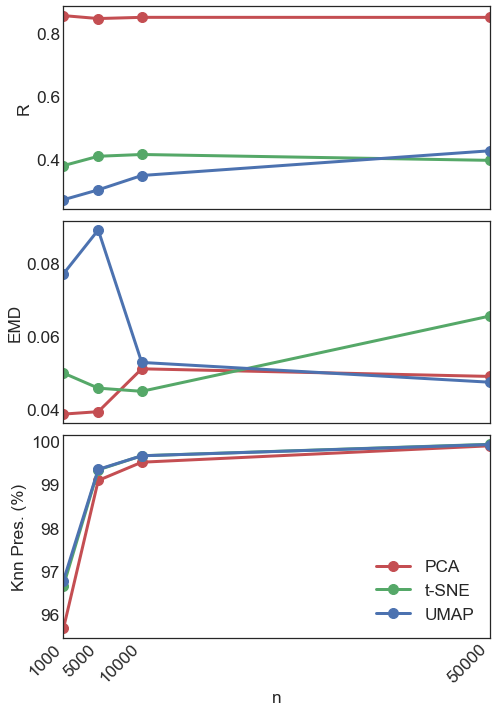

In [27]:
styles=['ro-', 'go-', 'bo-']
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,10), sharex='col')
    R.plot(linewidth=3, style=styles, ms=10, ax=axes[0], legend=False)
    axes[0].set_ylabel('R', fontsize='xx-large')
    axes[0].tick_params(axis='both', which='major', labelsize='xx-large')
    EMD.plot(linewidth=3, style=styles, ms=10, ax=axes[1], legend=False)
    axes[1].set_ylabel('EMD', fontsize='xx-large')
    axes[1].tick_params(axis='both', which='major', labelsize='xx-large')
    knn.plot(linewidth=3, style=styles, ms=10, ax=axes[2])
    axes[2].set_ylabel('Knn Pres. (%)', fontsize='xx-large')
    axes[2].tick_params(axis='both', which='major', labelsize='xx-large')
    plt.xlabel('n', fontsize='xx-large')
    plt.xticks([1000,5000,10000,50000], fontsize='xx-large', rotation=45, ha='right')
    plt.legend(fontsize='xx-large')
    plt.tight_layout()
    plt.savefig('outputs/plots/synthetic_stats.png', dpi=1000)